In [93]:
import sys

sys.path.append("../quicfire_tools")
from quicfire_tools import outputs
from quicfire_tools.parameters import SimulationParameters

In [94]:
import zarr
import numpy as np
import xarray as xr
import rasterio as rio
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

In [95]:
DATA_PATH = Path("../tests/data")
SIMULATION_PATH = DATA_PATH / "crazy-canyon-simulation"
OUTPUT_PATH = SIMULATION_PATH / "Output"
DRAWFIRE_PATH = OUTPUT_PATH / "drawfire"

# Create simulation parameters object
SIM_PARAMS = SimulationParameters(
    nx=100,
    ny=100,
    nz=56,
    dx=1,
    dy=1,
    dz=1,
    wind_speed=6.5,
    wind_direction=270,
    sim_time=600,
    auto_kill=0,
    num_cpus=4,
    fuel_flag=4,
    ignition_flag=1,
    output_time=100,
    topo_flag=0,
)

In [96]:
# Initialize the SimulationOutputs object
sim_outputs = outputs.SimulationOutputs(OUTPUT_PATH, SIM_PARAMS)
zarr_simulation_outputs = sim_outputs.to_zarr(DATA_PATH / "tmp/test.zarr", outputs="mburnt_integ")

In [97]:
zarr_simulation_outputs["mburnt_integ"][1, 50, 50, 0]

94.49690246582031

In [98]:
# Load the QUIC-Fire mburnt_integ output into an xarray DataArray
da = xr.open_zarr(DATA_PATH / "tmp/test.zarr", consolidated=False)["mburnt_integ"]
da

<xarray.DataArray 'mburnt_integ' (time: 2, y: 100, x: 100, z: 1)>
dask.array<open_dataset-mburnt_integ, shape=(2, 100, 100, 1), dtype=float64, chunksize=(1, 100, 100, 1), chunktype=numpy.ndarray>
Dimensions without coordinates: time, y, x, z

EPSG:5070


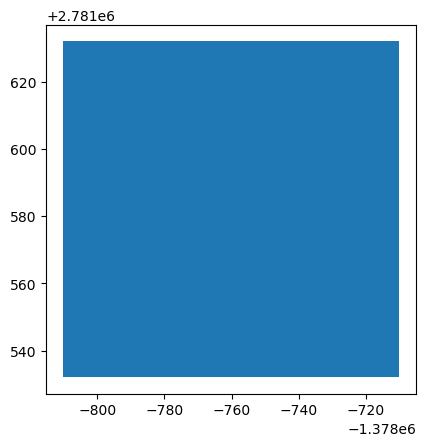

In [100]:
# Load a pretend shapefile of the area of interest
roi = gpd.read_file("data/blue_mtn_100m.geojson")
print(roi.crs)

In [101]:
# Set the CRS of the DataArray
da = da.rio.write_crs(roi.crs)
da.rio.crs

CRS.from_epsg(5070)

In [102]:
# Set the transform of the DataArray
west = roi.total_bounds[0]
north = roi.total_bounds[3]
transform = rio.transform.from_origin(west, north, SIM_PARAMS.dx, SIM_PARAMS.dy)
da = da.rio.write_transform(transform)

In [103]:
print(da.rio.transform)

<bound method XRasterBase.transform of <rioxarray.raster_array.RasterArray object at 0x164904990>>


In [104]:
# Assign coordinates to the DataArray
da = da.assign_coords(
    x=da.x.values * SIM_PARAMS.dx + west,
    y=da.y.values * -SIM_PARAMS.dy + north,
)

In [105]:
da

<xarray.DataArray 'mburnt_integ' (time: 2, y: 100, x: 100, z: 1)>
dask.array<open_dataset-mburnt_integ, shape=(2, 100, 100, 1), dtype=float64, chunksize=(1, 100, 100, 1), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -1.379e+06 -1.379e+06 ... -1.379e+06 -1.379e+06
  * y            (y) float64 2.782e+06 2.782e+06 ... 2.782e+06 2.782e+06
Dimensions without coordinates: time, z

In [106]:
da[0, ..., 0]

<xarray.DataArray 'mburnt_integ' (y: 100, x: 100)>
dask.array<getitem, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -1.379e+06 -1.379e+06 ... -1.379e+06 -1.379e+06
  * y            (y) float64 2.782e+06 2.782e+06 ... 2.782e+06 2.782e+06

In [123]:
da.transpose("time", "z", "y", "x").isel(time=1, z=0)

<xarray.DataArray 'mburnt_integ' (y: 100, x: 100)>
dask.array<getitem, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -1.379e+06 -1.379e+06 ... -1.379e+06 -1.379e+06
  * y            (y) float64 2.782e+06 2.782e+06 ... 2.782e+06 2.782e+06

In [124]:
# Write the RasterArray to a GeoTIFF
da.transpose("time", "z", "y", "x").isel(time=1, z=0).rio.to_raster("data/test.tif")

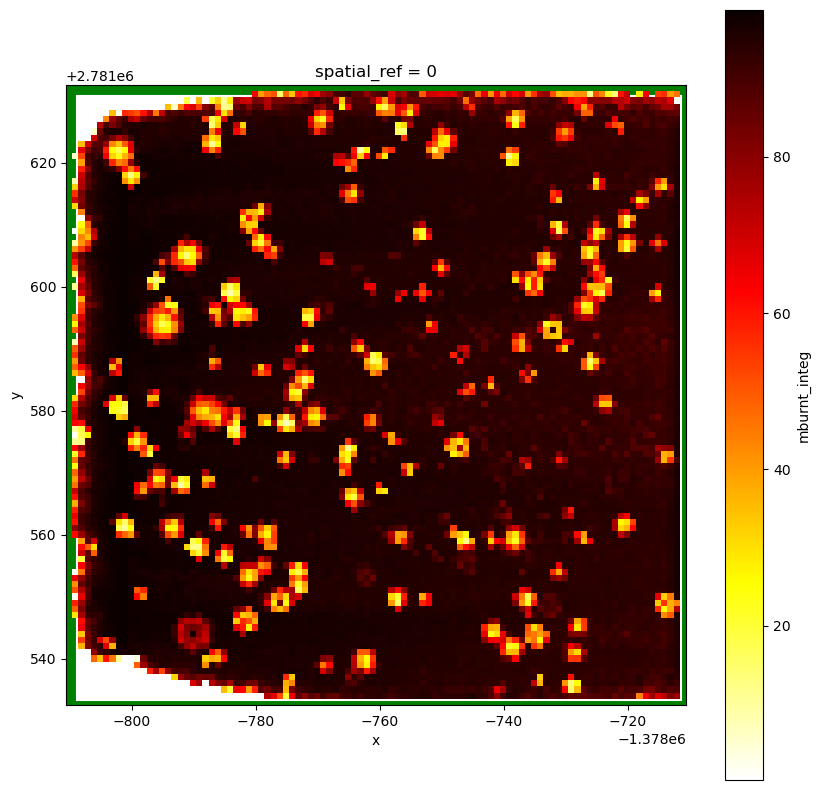

In [133]:
# Plot the DataArray over the shapefile
fig, ax = plt.subplots(figsize=(10, 10))
roi.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=10)
da.transpose("time", "z", "y", "x").isel(time=1, z=0).plot(ax=ax, cmap="hot_r")
plt.show()